In [1]:
import kagglehub
import json
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek, SMOTEENN
import warnings
warnings.filterwarnings('ignore')

## **Code Block 5.1**
**Data ingestion and target variable % distribution**


In [2]:
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
print("Path to dataset files:", path)

download_path = path
print(os.listdir(download_path))

# fraud labels
fraud_labels_path = os.path.join(download_path, 'train_fraud_labels.json')
with open(fraud_labels_path, 'r') as f:
    fraud_labels = json.load(f)

# Count labels
actual_labels = fraud_labels.get('target', {})
label_counts = {}
for label in actual_labels.values():
    label_counts[label] = label_counts.get(label, 0) + 1

print("Fraud label counts:")
print(label_counts)

# transactions data
transactions_data_path = os.path.join(download_path, 'transactions_data.csv')
transactions_df = pd.read_csv(transactions_data_path)

# Merge fraud labels with transactions data
fraud_series = pd.Series(actual_labels, name='is_fraud')
fraud_series.index = fraud_series.index.astype(transactions_df['id'].dtype)

merged_df = transactions_df.merge(fraud_series, left_on='id', right_index=True, how='left')
merged_df['is_fraud'] = merged_df['is_fraud'].fillna('No')

display(merged_df.head())
display(merged_df['is_fraud'].value_counts(normalize=True))

100%|██████████| 348M/348M [00:05<00:00, 63.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1
['train_fraud_labels.json', 'transactions_data.csv', 'mcc_codes.json', 'users_data.csv', 'cards_data.csv']
Fraud label counts:
{'No': 8901631, 'Yes': 13332}


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,No
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,No


,proportion
is_fraud,
No,0.998998
Yes,0.001002


## **Figure 22. Distribution of Fraudulent Transactions**

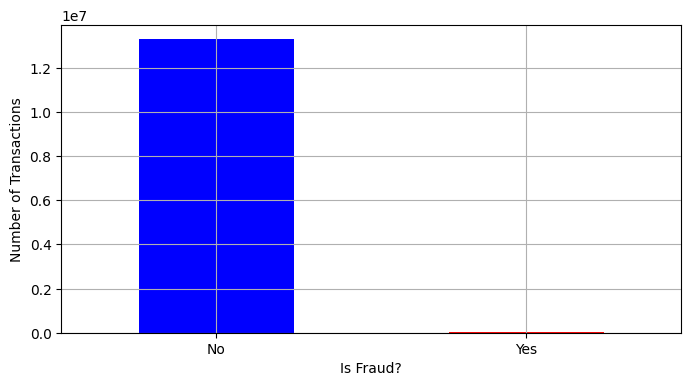

In [ ]:
fraud_counts = merged_df['is_fraud'].value_counts()

plt.figure(figsize=(8, 4))
fraud_counts.plot(kind='bar', color=['blue', 'red'])
# plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud?')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [ ]:
merged_df.shape

(13305915, 13)

## **Code Block 5.2**
**Prepare the data for modeling**


In [3]:
def preprocess_data(df):
    data = merged_df.copy()

    data['amount'] = data['amount'].replace('[\$,]', '', regex=True).astype(float)

    # Convert date to datetime and extract useful features
    data['date'] = pd.to_datetime(data['date'])
    data['hour'] = data['date'].dt.hour
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month

    # Encode categorical variables
    categorical_cols = ['use_chip', 'merchant_city', 'merchant_state', 'mcc', 'errors']

    label_encoders = {}
    for col in categorical_cols:
        if col in data.columns:
            le = LabelEncoder()
            # Fill NaN values with 'Unknown' before encoding
            data[col] = data[col].fillna('Unknown')
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le

    # Encode target variable
    data['is_fraud'] = data['is_fraud'].map({'No': 0, 'Yes': 1})

    return data, label_encoders

# Preprocess data
processed_df, encoders = preprocess_data(merged_df)

# Features for modeling
feature_columns = ['amount', 'use_chip', 'merchant_city', 'merchant_state',
                   'mcc', 'errors', 'hour', 'day_of_week', 'month']

X = processed_df[feature_columns]
y = processed_df['is_fraud']

# Class imbalance using class weights
class_weights = {0: 1, 1: len(y[y==0]) / len(y[y==1])}

## **Code Block 5.3**
**Logistic Regression model and accuracy**


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
logreg = LogisticRegression(
    class_weight=class_weights,
    random_state=42,
    max_iter=1000)

logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_train_scaled)
probs = logreg.predict_proba(X_train_scaled)
y_pred_prob = probs[:, 1]
print ("Accuracy: ", metrics.accuracy_score(y_train, y_pred))

Accuracy:  0.7012310315284074


## **Code Block 5.4**
**Determining Optimal Classification Threshold Using ROC and Precision-Recall Curves**


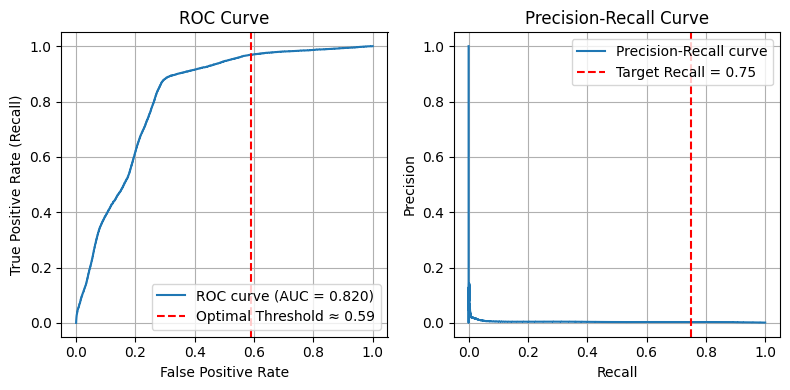

Optimal threshold for target recall 0.75: 0.5913


In [ ]:
y_pred_prob_train = logreg.predict_proba(X_train_scaled)[:, 1]

# ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_train, y_pred_prob_train)

target_recall = 0.75
idx_recall = np.argmin(np.abs(recall - target_recall))
optimal_threshold = pr_thresholds[idx_recall]

# ROC
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ≈ {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Precision-Recall
plt.subplot(1,2,2)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.axvline(x=recall[idx_recall], color='red', linestyle='--', label=f'Target Recall = {recall[idx_recall]:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Optimal threshold for target recall {target_recall}: {optimal_threshold:.4f}")

## **Code Block 5.5**
**Optimal Threshold Selection Using F1-Score and Youden’s J Statistic**


In [ ]:
prec, rec, thresholds = precision_recall_curve(y_train, y_pred_prob)
f1_scores = 2 * (prec * rec) / (prec + rec)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]
print(f"Optimal Threshold by F1-score: {optimal_threshold_f1:.4f}")

# Youden's J statistic for optimal threshold
fpr, tpr, roc_thresholds = roc_curve(y_train, y_pred_prob)
youden_j = tpr - fpr
optimal_idx_roc = np.argmax(youden_j)
optimal_threshold_roc = roc_thresholds[optimal_idx_roc]
print(f"Optimal Threshold by ROC (Youden's J): {optimal_threshold_roc:.4f}")


Optimal Threshold by F1-score: 1.0000
Optimal Threshold by ROC (Youden's J): 0.5073


## **Code Block 5.6**
**Integrated Evaluation Pipeline for Logistic Regression on Fraud Data**


In [ ]:
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

metrics_table = pd.DataFrame({
    "Metric": [
        "Accuracy",
        "Precision (Fraud = 1)",
        "Recall (Fraud = 1)",
        "F1-Score (Fraud = 1)",
        "ROC-AUC",
        "Fraud Rate (Train)",
        "Fraud Rate (Test)"],
    "Value": [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred_proba),
        y_train.mean(),
        y_test.mean()]})

print("\n=== Logistic Regression Results ===")
print("=" * 60)
print(metrics_table.to_string(index=False))

cm = confusion_matrix(y_test, y_pred)
cm_table = pd.DataFrame(
    cm,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"])

print("\n=== Confusion Matrix ===")
print(cm_table)

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': logreg.coef_[0],
    'abs_importance': np.abs(logreg.coef_[0])
}).sort_values('abs_importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance.to_string(index=False))

print("\n=== Sample Predictions ===")
sample_indices = X_test.index[:5]

for idx in sample_indices:
    actual = y.loc[idx]
    row = X_test_scaled[X_test.index == idx]
    pred = logreg.predict(row)[0]
    proba = logreg.predict_proba(row)[0][1]

    print(f"Transaction {idx}: Actual={actual}, Predicted={pred}, Fraud Probability={proba:.4f}")


=== Logistic Regression Results ===
               Metric    Value
             Accuracy 0.701479
Precision (Fraud = 1) 0.002938
   Recall (Fraud = 1) 0.877500
 F1-Score (Fraud = 1) 0.005857
              ROC-AUC 0.816472
   Fraud Rate (Train) 0.001002
    Fraud Rate (Test) 0.001002

=== Confusion Matrix ===
          Predicted 0  Predicted 1
Actual 0      2796636      1191139
Actual 1          490         3510

=== Feature Importance ===
       feature  coefficient  abs_importance
 merchant_city     1.164865        1.164865
merchant_state     0.859891        0.859891
      use_chip    -0.558652        0.558652
        amount     0.297438        0.297438
           mcc    -0.143728        0.143728
        errors    -0.098641        0.098641
   day_of_week     0.068666        0.068666
          hour    -0.042295        0.042295
         month     0.024115        0.024115

=== Sample Predictions ===
Transaction 9324586: Actual=0, Predicted=0, Fraud Probability=0.0445
Transaction 3160624

## **Code Block 5.7**
**Evaluating Model Performance Using Optimal Probability Threshold**

In [ ]:
y_pred_prob_train = logreg.predict_proba(X_train_scaled)[:, 1]
y_pred_train = logreg.predict(X_train_scaled)

y_pred_optimal_train = np.where(y_pred_prob_train >= optimal_threshold, 1, 0)
print("\nTraining Set Performance")
print("-" * 60)
print(f"Default Threshold (0.5) - Accuracy: {metrics.accuracy_score(y_train, y_pred_train):.4f}")
print(f"Optimal Threshold ({optimal_threshold:.4f}) - Accuracy: {metrics.accuracy_score(y_train, y_pred_optimal_train):.4f}")


print("\nDefault Threshold - Confusion Matrix:")
print("-" * 60)
print(metrics.confusion_matrix(y_train, y_pred_train))
print(f"\nOptimal Threshold ({optimal_threshold:.4f}) - Confusion Matrix:")
print("-" * 60)
print(metrics.confusion_matrix(y_train, y_pred_optimal_train))


y_pred_optimal_test = np.where(y_pred_proba >= optimal_threshold, 1, 0)
print("\nTest Set Performance with Optimal Threshold")
print("-" * 60)
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_optimal_test):.4f}")
print("\nTest Confusion Matrix:")
print("-" * 60)
print(metrics.confusion_matrix(y_test, y_pred_optimal_test))
print("\nTest Classification Report:")
print("-" * 60)
print(metrics.classification_report(y_test, y_pred_optimal_test))


Training Set Performance
------------------------------------------------------------
Default Threshold (0.5) - Accuracy: 0.7012
Optimal Threshold (0.5913) - Accuracy: 0.7543

Default Threshold - Confusion Matrix:
------------------------------------------------------------
[[6523141 2781667]
 [   1109    8223]]

Optimal Threshold (0.5913) - Confusion Matrix:
------------------------------------------------------------
[[7018841 2285967]
 [   2333    6999]]

Test Set Performance with Optimal Threshold
------------------------------------------------------------
Test Accuracy: 0.7545

Test Confusion Matrix:
------------------------------------------------------------
[[3008705  979070]
 [   1007    2993]]

Test Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.75      0.86   3987775
           1       0.00      0.75      0.01      4000

    accuracy                   

## **Figure 24. Linkage of Threshold with False Positives and False Negatives**

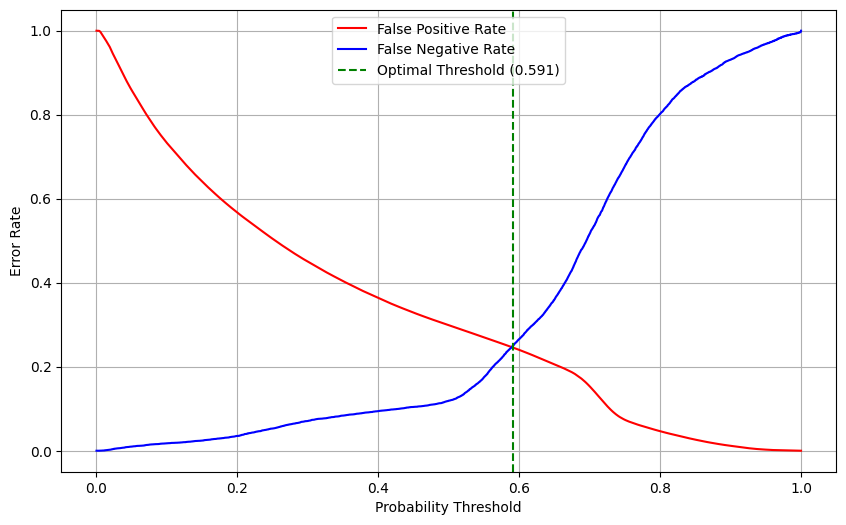

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)
fnr = 1 - tpr  # False Negative Rate

plt.figure(figsize=(10,6))
plt.plot(thresholds, fpr, label='False Positive Rate', color='red')
plt.plot(thresholds, fnr, label='False Negative Rate', color='blue')
plt.axvline(optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.xlabel('Probability Threshold')
plt.ylabel('Error Rate')
# plt.title('Linkage of Threshold with False Positives and False Negatives')
plt.legend()
plt.grid(True)
plt.show()


Positive class: 514
Negative class: 4486


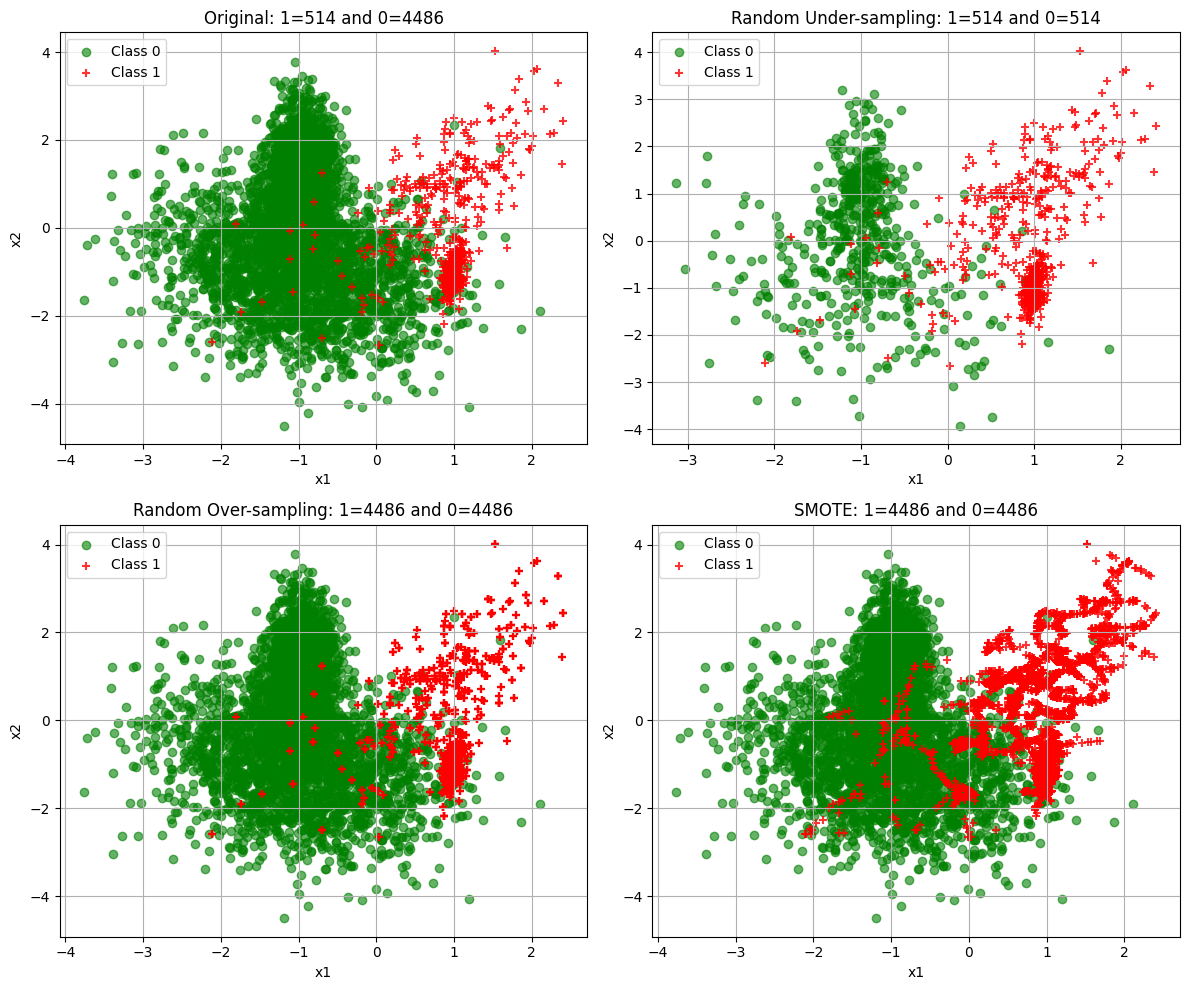


=== Resampling Results Summary ===
Original dataset: 5000 samples (Class 0: 4486, Class 1: 514)
Random Under-sampling: 1028 samples (Class 0: 514, Class 1: 514)
Random Over-sampling: 8972 samples (Class 0: 4486, Class 1: 4486)
SMOTE: 8972 samples (Class 0: 4486, Class 1: 4486)


In [ ]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                          n_redundant=0, weights=[0.9, 0.1], random_state=2017)
print(f"Positive class: {y.tolist().count(1)}")
print(f"Negative class: {y.tolist().count(0)}")

# Random under-sampling
rus = RandomUnderSampler(random_state=2017)
X_RUS, y_RUS = rus.fit_resample(X, y)

# Random over-sampling
ros = RandomOverSampler(random_state=2017)
X_ROS, y_ROS = ros.fit_resample(X, y)

# Regular SMOTE
sm = SMOTE(random_state=2017)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)

plt.figure(figsize=(12, 10))

# Original data
plt.subplot(2, 2, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original: 1=%s and 0=%s' % (y.tolist().count(1), y.tolist().count(0)))
plt.grid()
plt.legend()

# Random Under-sampling
plt.subplot(2, 2, 2)
plt.scatter(X_RUS[y_RUS==0, 0], X_RUS[y_RUS==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_RUS[y_RUS==1, 0], X_RUS[y_RUS==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random Under-sampling: 1=%s and 0=%s' % (y_RUS.tolist().count(1), y_RUS.tolist().count(0)))
plt.grid()
plt.legend()

# Random Over-sampling
plt.subplot(2, 2, 3)
plt.scatter(X_ROS[y_ROS==0, 0], X_ROS[y_ROS==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_ROS[y_ROS==1, 0], X_ROS[y_ROS==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random Over-sampling: 1=%s and 0=%s' % (y_ROS.tolist().count(1), y_ROS.tolist().count(0)))
plt.grid()
plt.legend()

# SMOTE
plt.subplot(2, 2, 4)
plt.scatter(X_SMOTE[y_SMOTE==0, 0], X_SMOTE[y_SMOTE==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_SMOTE[y_SMOTE==1, 0], X_SMOTE[y_SMOTE==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SMOTE: 1=%s and 0=%s' % (y_SMOTE.tolist().count(1), y_SMOTE.tolist().count(0)))
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== Resampling Results Summary ===")
print(f"Original dataset: {X.shape[0]} samples (Class 0: {y.tolist().count(0)}, Class 1: {y.tolist().count(1)})")
print(f"Random Under-sampling: {X_RUS.shape[0]} samples (Class 0: {y_RUS.tolist().count(0)}, Class 1: {y_RUS.tolist().count(1)})")
print(f"Random Over-sampling: {X_ROS.shape[0]} samples (Class 0: {y_ROS.tolist().count(0)}, Class 1: {y_ROS.tolist().count(1)})")
print(f"SMOTE: {X_SMOTE.shape[0]} samples (Class 0: {y_SMOTE.tolist().count(0)}, Class 1: {y_SMOTE.tolist().count(1)})")

## **Figure 25. Comparative Analysis of Resampling Techniques for Class Imbalance**

Positive class: 514
Negative class: 4486


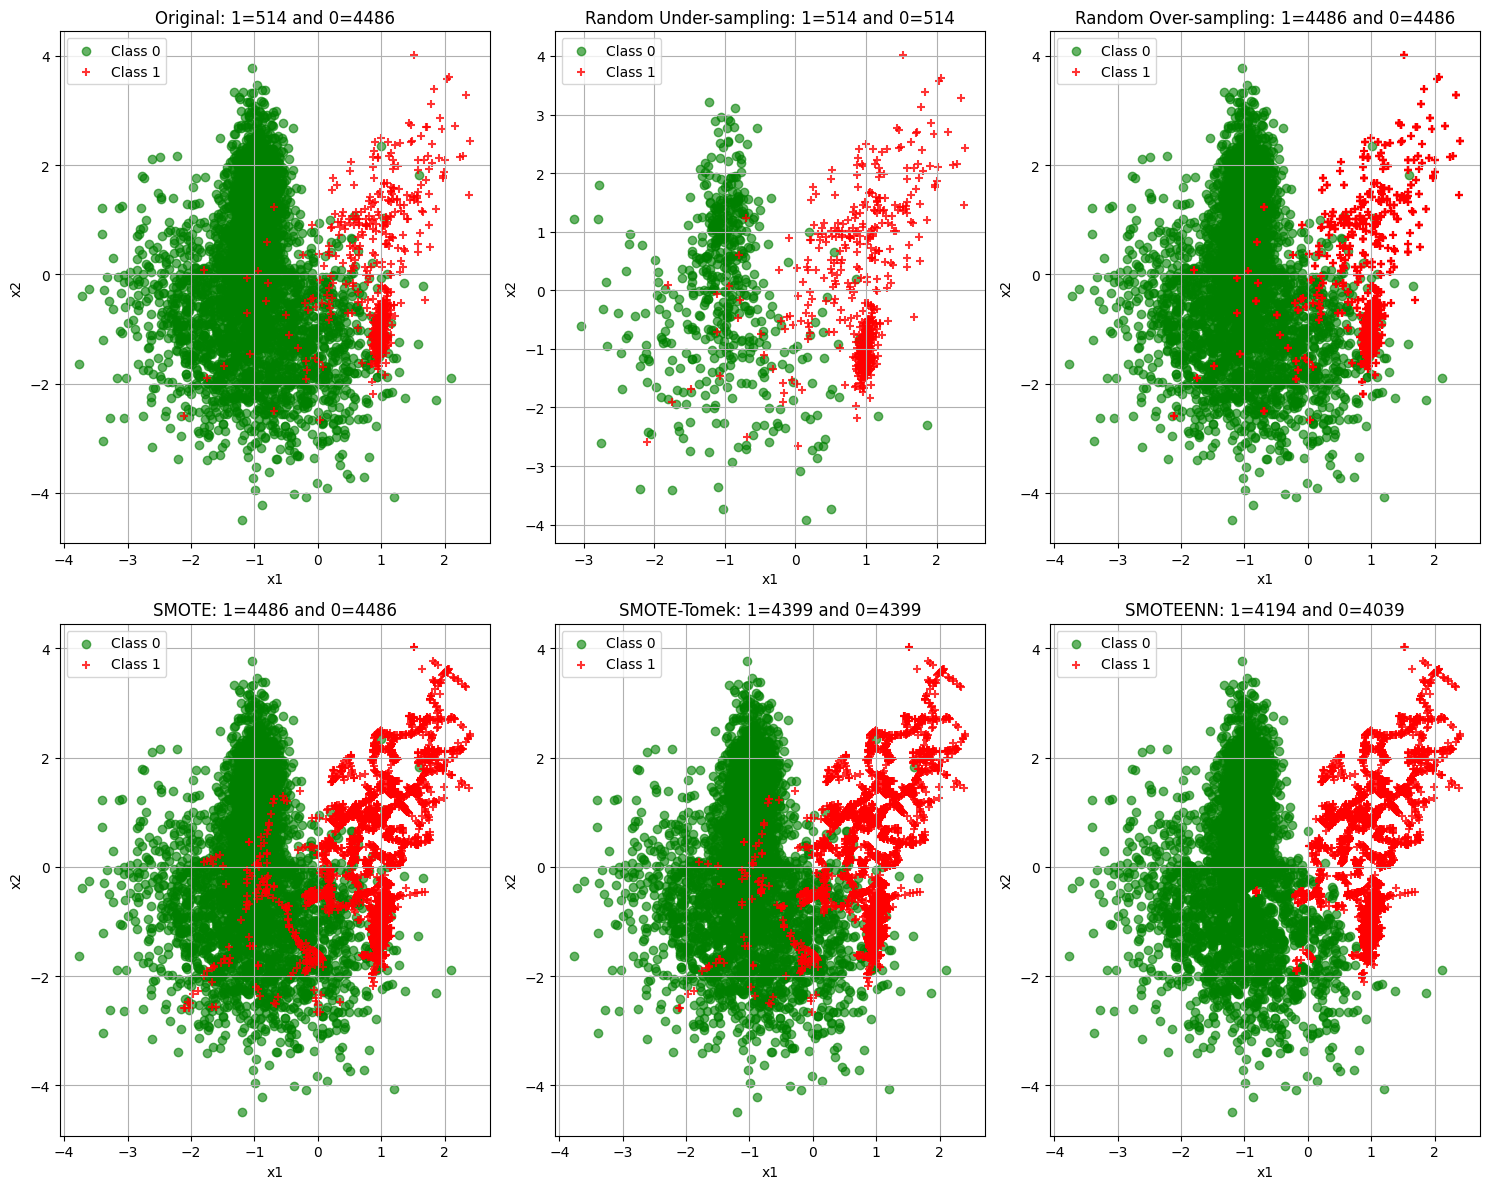


=== Resampling Results Summary ===
Original dataset: 5000 samples (Class 0: 4486, Class 1: 514)
Random Under-sampling: 1028 samples (Class 0: 514, Class 1: 514)
Random Over-sampling: 8972 samples (Class 0: 4486, Class 1: 4486)
SMOTE: 8972 samples (Class 0: 4486, Class 1: 4486)
SMOTE-Tomek: 8798 samples (Class 0: 4399, Class 1: 4399)
SMOTEENN: 8233 samples (Class 0: 4039, Class 1: 4194)


In [3]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                          n_redundant=0, weights=[0.9, 0.1], random_state=2017)
print(f"Positive class: {y.tolist().count(1)}")
print(f"Negative class: {y.tolist().count(0)}")

# Random under-sampling
rus = RandomUnderSampler(random_state=2017)
X_RUS, y_RUS = rus.fit_resample(X, y)

# Random over-sampling
ros = RandomOverSampler(random_state=2017)
X_ROS, y_ROS = ros.fit_resample(X, y)

# Regular SMOTE
sm = SMOTE(random_state=2017)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)

# SMOTE-Tomek
smt = SMOTETomek(random_state=2017)
X_SMOTE_TOMEK, y_SMOTE_TOMEK = smt.fit_resample(X, y)

# SMOTEENN
sme = SMOTEENN(random_state=2017)
X_SMOTEENN, y_SMOTEENN = sme.fit_resample(X, y)

plt.figure(figsize=(15, 12))

# Original data
plt.subplot(2, 3, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original: 1=%s and 0=%s' % (y.tolist().count(1), y.tolist().count(0)))
plt.grid()
plt.legend()

# Random Under-sampling
plt.subplot(2, 3, 2)
plt.scatter(X_RUS[y_RUS==0, 0], X_RUS[y_RUS==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_RUS[y_RUS==1, 0], X_RUS[y_RUS==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random Under-sampling: 1=%s and 0=%s' % (y_RUS.tolist().count(1), y_RUS.tolist().count(0)))
plt.grid()
plt.legend()

# Random Over-sampling
plt.subplot(2, 3, 3)
plt.scatter(X_ROS[y_ROS==0, 0], X_ROS[y_ROS==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_ROS[y_ROS==1, 0], X_ROS[y_ROS==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random Over-sampling: 1=%s and 0=%s' % (y_ROS.tolist().count(1), y_ROS.tolist().count(0)))
plt.grid()
plt.legend()

# SMOTE
plt.subplot(2, 3, 4)
plt.scatter(X_SMOTE[y_SMOTE==0, 0], X_SMOTE[y_SMOTE==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_SMOTE[y_SMOTE==1, 0], X_SMOTE[y_SMOTE==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SMOTE: 1=%s and 0=%s' % (y_SMOTE.tolist().count(1), y_SMOTE.tolist().count(0)))
plt.grid()
plt.legend()

# SMOTE-Tomek
plt.subplot(2, 3, 5)
plt.scatter(X_SMOTE_TOMEK[y_SMOTE_TOMEK==0, 0], X_SMOTE_TOMEK[y_SMOTE_TOMEK==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_SMOTE_TOMEK[y_SMOTE_TOMEK==1, 0], X_SMOTE_TOMEK[y_SMOTE_TOMEK==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SMOTE-Tomek: 1=%s and 0=%s' % (y_SMOTE_TOMEK.tolist().count(1), y_SMOTE_TOMEK.tolist().count(0)))
plt.grid()
plt.legend()

# SMOTEENN
plt.subplot(2, 3, 6)
plt.scatter(X_SMOTEENN[y_SMOTEENN==0, 0], X_SMOTEENN[y_SMOTEENN==0, 1], marker='o', color='green', alpha=0.6, label='Class 0')
plt.scatter(X_SMOTEENN[y_SMOTEENN==1, 0], X_SMOTEENN[y_SMOTEENN==1, 1], marker='+', color='red', alpha=0.8, label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SMOTEENN: 1=%s and 0=%s' % (y_SMOTEENN.tolist().count(1), y_SMOTEENN.tolist().count(0)))
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== Resampling Results Summary ===")
print(f"Original dataset: {X.shape[0]} samples (Class 0: {y.tolist().count(0)}, Class 1: {y.tolist().count(1)})")
print(f"Random Under-sampling: {X_RUS.shape[0]} samples (Class 0: {y_RUS.tolist().count(0)}, Class 1: {y_RUS.tolist().count(1)})")
print(f"Random Over-sampling: {X_ROS.shape[0]} samples (Class 0: {y_ROS.tolist().count(0)}, Class 1: {y_ROS.tolist().count(1)})")
print(f"SMOTE: {X_SMOTE.shape[0]} samples (Class 0: {y_SMOTE.tolist().count(0)}, Class 1: {y_SMOTE.tolist().count(1)})")
print(f"SMOTE-Tomek: {X_SMOTE_TOMEK.shape[0]} samples (Class 0: {y_SMOTE_TOMEK.tolist().count(0)}, Class 1: {y_SMOTE_TOMEK.tolist().count(1)})")
print(f"SMOTEENN: {X_SMOTEENN.shape[0]} samples (Class 0: {y_SMOTEENN.tolist().count(0)}, Class 1: {y_SMOTEENN.tolist().count(1)})")

## **Code Block 5.8**
**Decision Tree Classifier Evaluation with Cross-Validation**

In [ ]:
clf = DecisionTreeClassifier(random_state = 2025)
# 5-fold CV
train_scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv=5)
test_scores = cross_val_score(clf, X_test, y_test, scoring = 'accuracy', cv=5)
print ("Train Fold AUC Scores: ", train_scores)
print ("Train CV AUC Score: ", train_scores.mean())
print ("\nTest Fold AUC Scores: ", test_scores)
print ("Test CV AUC Score: ", test_scores.mean())

Train Fold AUC Scores:  [0.99887429 0.99883564 0.99885014 0.99887698 0.99887537]
Train CV AUC Score:  0.9988624822044763

Test Fold AUC Scores:  [0.99884513 0.99880755 0.99879377 0.99888521 0.99881256]
Test CV AUC Score:  0.9988288418059635


## **Code Block 5.9**
**Stratified kfold cross-validation**


In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 2025)
train_scores = []
test_scores = []

for k, (train_idx, test_idx) in enumerate(kfold.split(X_train, y_train)):
    clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    train_score = clf.score(X_train.iloc[train_idx], y_train.iloc[train_idx])
    train_scores.append(train_score)

    test_score = clf.score(X_train.iloc[test_idx], y_train.iloc[test_idx])
    test_scores.append(test_score)

    print('Fold: %s, Class dist.: %s, Train Acc: %.3f, Validation Acc: %.3f'
          % (k+1, np.bincount(y_train.iloc[train_idx]), train_score, test_score))

print('\nTrain CV accuracy: %.3f +/- %.3f' % (np.mean(train_scores), np.std(train_scores)))
print('Validation CV accuracy: %.3f +/- %.3f' % (np.mean(test_scores), np.std(test_scores)))

Fold: 1, Class dist.: [7443846    7466], Train Acc: 1.000, Validation Acc: 0.999
Fold: 2, Class dist.: [7443846    7466], Train Acc: 1.000, Validation Acc: 0.999
Fold: 3, Class dist.: [7443846    7466], Train Acc: 1.000, Validation Acc: 0.999
Fold: 4, Class dist.: [7443847    7465], Train Acc: 1.000, Validation Acc: 0.999
Fold: 5, Class dist.: [7443847    7465], Train Acc: 1.000, Validation Acc: 0.999

Train CV accuracy: 1.000 +/- 0.000
Validation CV accuracy: 0.999 +/- 0.000


## **Code Block 5.10**
**Toy Example: Demonstrating Data Leakage Using a Leaky Feature**


In [2]:
np.random.seed(2025)
n = 5000

# useful features
X1 = np.random.randn(n)
X2 = np.random.randn(n)

# Fraud label (imbalanced)
y = (0.1 * X1 + 0.5 * X2 + np.random.randn(n) * 0.5 > 0.5).astype(int)

df = pd.DataFrame({"X1": X1, "X2": X2, "y": y})

# LEAKY FEATURE: this feature intentionally correlates with the target

df["future_fraud_count"] = df["y"] + np.random.normal(0, 0.01, n)

X = df[["X1", "X2", "future_fraud_count"]]
y = df["y"]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
train_scores = []
test_scores = []

clf = LogisticRegression()

for k, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])

    train_score = clf.score(X.iloc[train_idx], y.iloc[train_idx])
    test_score = clf.score(X.iloc[test_idx], y.iloc[test_idx])

    train_scores.append(train_score)
    test_scores.append(test_score)

    print(f"Fold {k+1}: Train={train_score:.3f}, Validation={test_score:.3f}")

print("\nTrain CV accuracy: %.3f +/- %.3f" % (np.mean(train_scores), np.std(train_scores)))
print("Validation CV accuracy: %.3f +/- %.3f" % (np.mean(test_scores), np.std(test_scores)))
print()

X_clean = df[["X1", "X2"]]
y = df["y"]

train_scores = []
test_scores = []

for k, (train_idx, test_idx) in enumerate(kfold.split(X_clean, y)):
    clf.fit(X_clean.iloc[train_idx], y.iloc[train_idx])

    train_score = clf.score(X_clean.iloc[train_idx], y.iloc[train_idx])
    test_score = clf.score(X_clean.iloc[test_idx], y.iloc[test_idx])

    train_scores.append(train_score)
    test_scores.append(test_score)

    print(f"Fold {k+1}: Train={train_score:.3f}, Validation={test_score:.3f}")

print("\nTrain CV accuracy: %.3f +/- %.3f" % (np.mean(train_scores), np.std(train_scores)))
print("Validation CV accuracy: %.3f +/- %.3f" % (np.mean(test_scores), np.std(test_scores)))


Fold 1: Train=1.000, Validation=1.000
Fold 2: Train=1.000, Validation=1.000
Fold 3: Train=1.000, Validation=1.000
Fold 4: Train=1.000, Validation=1.000
Fold 5: Train=1.000, Validation=1.000

Train CV accuracy: 1.000 +/- 0.000
Validation CV accuracy: 1.000 +/- 0.000

Fold 1: Train=0.824, Validation=0.836
Fold 2: Train=0.828, Validation=0.823
Fold 3: Train=0.823, Validation=0.839
Fold 4: Train=0.829, Validation=0.817
Fold 5: Train=0.829, Validation=0.817

Train CV accuracy: 0.827 +/- 0.002
Validation CV accuracy: 0.826 +/- 0.009


## **Code Block 5.11**
**Toy Example: Temporal Cross-Validation Accuracy Over Time**


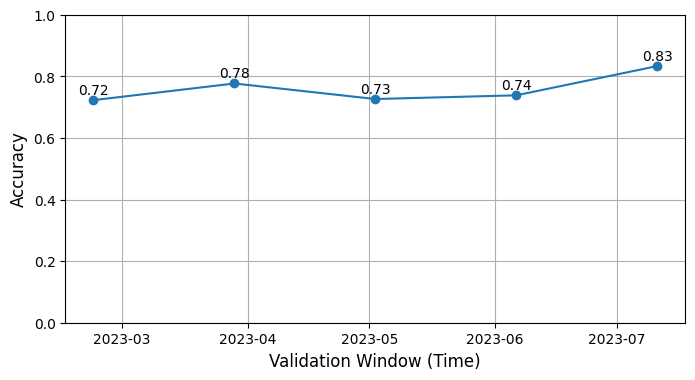

In [9]:
np.random.seed(2025)
n = 5000

df = pd.DataFrame({
    "timestamp": pd.date_range("2023-01-01", periods=n, freq="h"),
    "feature1": np.random.randn(n),
    "feature2": np.random.randn(n),})

# Fraud label changes over time (concept drift)
df["fraud"] = (
    df["feature1"] * 0.3 +
    df["feature2"] * 0.5 +
    np.sin(np.arange(n) / 200) +
    np.random.randn(n) * 0.5 > 0.7
).astype(int)

df = df.sort_values("timestamp").reset_index(drop=True)

clf = LogisticRegression()
window_splits = 5
split_size = n // (window_splits + 1)

accuracies = []
test_times = []

for i in range(1, window_splits + 1):
    train_end = split_size * i
    test_end = split_size * (i + 1)

    train_df = df.iloc[:train_end]
    test_df = df.iloc[train_end:test_end]

    clf.fit(train_df[["feature1", "feature2"]], train_df["fraud"])
    preds = clf.predict(test_df[["feature1", "feature2"]])
    acc = accuracy_score(test_df["fraud"], preds)

    accuracies.append(acc)
    test_times.append(test_df["timestamp"].iloc[len(test_df)//2])

plt.figure(figsize=(8, 4))
plt.plot(test_times, accuracies, marker="o")

plt.title("Temporal Cross-Validation Accuracy Over Time", fontsize=14)
plt.xlabel("Validation Window (Time)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.ylim(0, 1)

for i, acc in enumerate(accuracies):
    plt.text(test_times[i], acc + 0.02, f"{acc:.2f}", ha="center")

plt.show()

## **Code Block 5.12:**
 **Comparison: Temporal CV vs. Random CV**

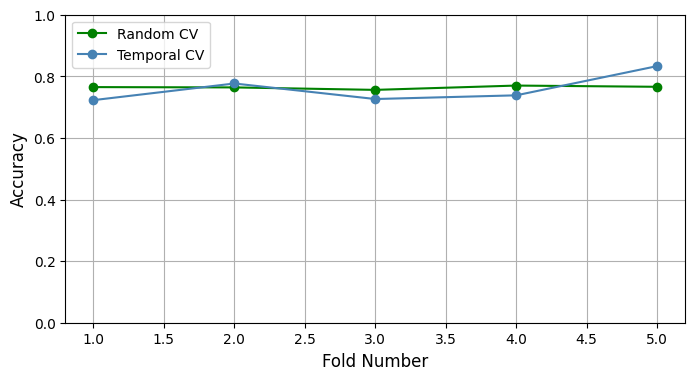

In [11]:
np.random.seed(2025)
n = 5000

df = pd.DataFrame({
    "timestamp": pd.date_range("2023-01-01", periods=n, freq="h"),
    "feature1": np.random.randn(n),
    "feature2": np.random.randn(n),})

# Fraud label changes over time (concept drift)
df["fraud"] = (
    df["feature1"] * 0.3 +
    df["feature2"] * 0.5 +
    np.sin(np.arange(n) / 200) +
    np.random.randn(n) * 0.5 > 0.7
).astype(int)

df = df.sort_values("timestamp").reset_index(drop=True)

X = df[["feature1", "feature2"]]
y = df["fraud"]

# Temporal CV (expanding window)
clf = LogisticRegression()
window_splits = 5
split_size = n // (window_splits + 1)

temporal_acc = []

for i in range(1, window_splits + 1):
    train_end = split_size * i
    test_end = split_size * (i + 1)

    train_df = df.iloc[:train_end]
    test_df = df.iloc[train_end:test_end]

    clf.fit(train_df[["feature1", "feature2"]], train_df["fraud"])
    preds = clf.predict(test_df[["feature1", "feature2"]])
    acc = accuracy_score(test_df["fraud"], preds)
    temporal_acc.append(acc)

# Random CV (Stratified K-Fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

random_acc = []

for train_idx, test_idx in skf.split(X, y):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = clf.predict(X.iloc[test_idx])
    acc = accuracy_score(y.iloc[test_idx], preds)
    random_acc.append(acc)


plt.figure(figsize=(8, 4))

plt.plot(range(1, 6), random_acc, marker="o", label="Random CV", color="green")
plt.plot(range(1, 6), temporal_acc, marker="o", label="Temporal CV", color="steelblue")

# plt.title("Comparison: Temporal CV vs. Random CV Accuracy", fontsize=14)
plt.xlabel("Fold Number", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()


## **Figure 30. Temporal CV vs. Time Series CV vs. Gap CV**

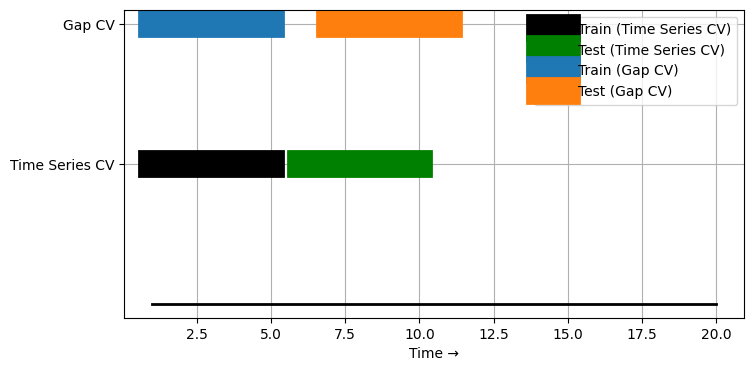

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))

timeline = list(range(1, 21))
ax.plot(timeline, [0]*20, 'k', linewidth=2)

# Training and test windows for Time Series CV
ax.plot(range(1, 6), [1]*5, color='k', linewidth=20, label='Train (Time Series CV)')
ax.plot(range(6, 11), [1]*5, color='green', linewidth=20, label='Test (Time Series CV)')

# Gap CV
ax.plot(range(1, 6), [2]*5, linewidth=20, label='Train (Gap CV)')
ax.plot(range(7, 12), [2]*5, linewidth=20, label='Test (Gap CV)')
ax.plot(range(6, 7), [2]*1)

ax.set_yticks([1, 2])
ax.set_yticklabels(['Time Series CV', 'Gap CV'])
ax.set_xlabel("Time →")
# ax.set_title("Temporal CV vs. Time Series CV vs. Gap CV")
ax.legend()
ax.grid()

plt.show()
